##*Elizabeth Torres Torrecillas* 


# *Evaluación 1*




---

---

---







In [271]:
#Bibliotecas a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [272]:
#La biblioteca Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

* Construcción de una Serie de Tiempo

In [273]:
#Guardamos el archivo .txt en la variable url
url='https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_mlo_DailyData.txt'

###DEPURAMOS EL DATA FRAME, SOLO NOS QUEDAMOS CON LOS DATOS DE INTERÉS A ANALIZAR
# sep='\s+' dar un espacio entre los datos 
# skipfooter=1, en el ultimo no hay encabezado
# engine='python'   procesar los datos usando python
# skiprows=151  nos saltamos las primeras 150 lineas de nuestro dataframe y empezamos en la 151
df = pd.read_csv(url, encoding='cp1251', sep='\s+', header=None, skiprows=151, skipfooter=1, engine='python')

#Borramos el primer renglón
#axis=0, significa el eje x
df = df.drop(0,axis=0)

#Creamos la columna fecha, esta se forma con las columnas ya existentes "day", "month", "year"
#orden en el que aparecerá day/month/year
df['Fecha'] = df[3].map(str) + "/" + df[2]+"/"+ df[1]

#Aquí vamos a convertir del tipo objeto a el formato que el lenguaje utilizado comprende
#Esto ya que la variable tipo fecha de Python, contiene mucha información condensada
#La función pd.to_datetime convierte una cadena en tipo datetime64[ns]
# Agregamos la opción de que el primer dato es el día (dayfirst=True) 
df['Fecha'] = pd.to_datetime(df['Fecha'],dayfirst=True,errors ='coerce')
#Formato de año
df['Año'] = df['Fecha'].dt.year
#Formato de mes
df['Mes'] = df['Fecha'].dt.month
#Formato de día
df['Dia'] = df['Fecha'].dt.day

#Convertimos la columna fecha a la principal, bold
df = df.set_index('Fecha')

#Borramos las columnas que no son de nuestro interés
#Las únicas que nos interesan son "value" que se encuentra en la columna 8
df = df.drop(range(0, 8),axis=1)
df = df.drop(range(9, 17),axis=1)

#Convertir a número flotante a la columna 8 que es la de 'Value'
df[8] = df[8].astype(float)

#La columna de 'value' que corresponde a las concentraciones de CO2. 
#Cuando hay datos faltantes, aparece el número -999.99 y lo reemplazamos por NaN 
#REMPLAZANDO
df = df.replace(to_replace= -999.99 ,value = np.nan,regex= True )

#Renombramos las columnas
df.columns = ['Value','Año','Mes','Dia']

#NUEVO DATAFRAME CON UN CONJUNTO DE DATOS
#Se construye un dataframe que contiene desde el inicio de 1980 hasta fin de 2019.
df_80 = df[(df['Año'] >= 1980) & (df['Año'] < 2019)].copy()
df_80.ffill(axis = 0 , inplace= True) 
#Vemos los primeros 5 datos
df_80.head()

,Value,Año,Mes,Dia
Fecha,,,,
1980-01-01,337.85,1980,1,1
1980-01-02,337.32,1980,1,2
1980-01-03,337.75,1980,1,3
1980-01-04,337.70,1980,1,4
1980-01-05,337.65,1980,1,5


* Análisis de una Serie de Tiempo

In [274]:
#Para probar la estacionaridad, haremos uso de La Prueba Aumentada de Dickey-Fuller (ADF)
#La función para probar la estacionaridad de una serie de tiempo: 'timeseries'
#Definimos una función para probar estacionaridad
def test_stationarity(df_ts):

  #Determinamos la estadística de los promedios móviles de 365
  rolmean = df_ts.rolling(window=365, center=True,min_periods=1).mean()
  rolstd = df_ts.rolling(window=365, center=True,min_periods=1).std() 
    
  #Tamaño de la figura
  plt.rcParams['figure.figsize'] = (12,6)

  #Graficamos la Estadística de promedios móviles 
  #Graficamos la serie 
  plt.plot(df_ts, color='green',label='Original')
  #Graficamos el promedio movil 
  plt.plot(rolmean, color='red', label='Rolling Mean')
  #Graficamos la desviación estandar 
  plt.plot(rolstd, color='blue', label = 'Rolling Std Deviation')
  plt.legend(loc='best')
  plt.title('Promedio Móvil y Desviación Estándar')
  #Se desea que la gráfica tenga una malla
  plt.grid()
  plt.show()
 
  ##Si el valor de "p" es menor a 5%, la serie es estacionaria
  ##Si el valor de "p" es mayor a 5% la serie NO ES ESTACIONARIA, entonces le hacemos un tratamiento hasta lograrlo.
  #Realizamos la Prueba Aumentada de Dickey-Fuller 
  print('Resultados de la Prueba de Dickey-Fuller:')
  dftest = adfuller(df_ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
      index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

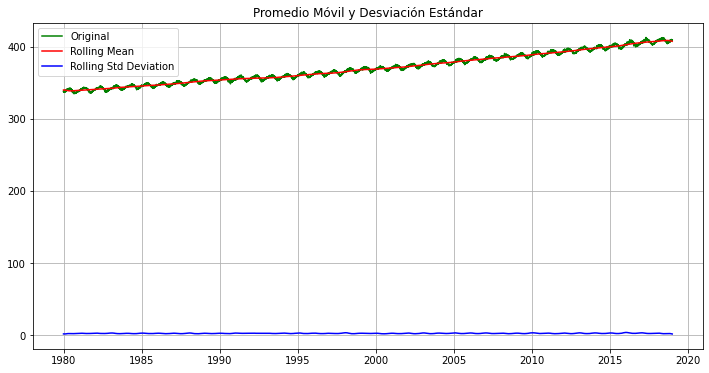

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.155189
p-value                            0.692569
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [275]:
#Definimos la Serie de Tiempo para Value 
ts_test = df_80['Value']
#se la damos como argumento a la prueba 
test_stationarity(ts_test)

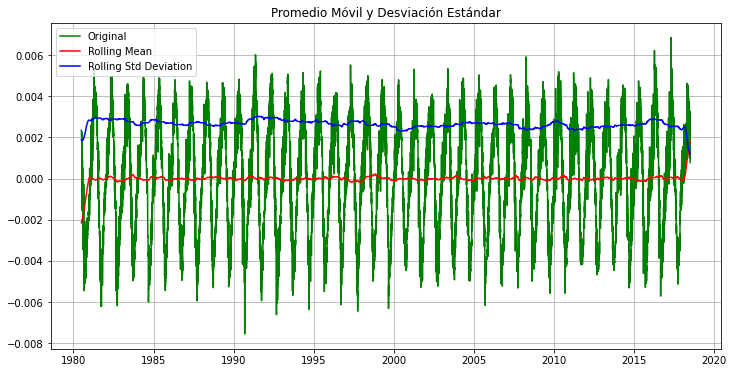

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.385363e+01
p-value                        6.931864e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [276]:
###NOTAMOS QUE EL VALOR DE P ES MAYOR AL 5% (0.692569)
#LA SERIE NO ES ESTACIONARIA
#TENEMOS QUE HACERLE UN TRATAMIENTO HASTA LOGRARLO

#TRATAMIENTO MEDIANTE LA FUNCIÓN LOGARITMO
#El cambio de escala se realizará con base en la función logaritmo
#Graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(test_va)

#Calculamos el promedio móvil con con ventana de 365 días 
moving_avg = ts_test_log.rolling(365, center=True).mean()
##Estacionaridad de la diferencial
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()
#probamos la estacionaridad 
test_stationarity(ts_test_log_moving_ave_diff)
#OBSERVACIÓN: VALOR DE P DISMINUYE NOTABLEMENTE <0.05

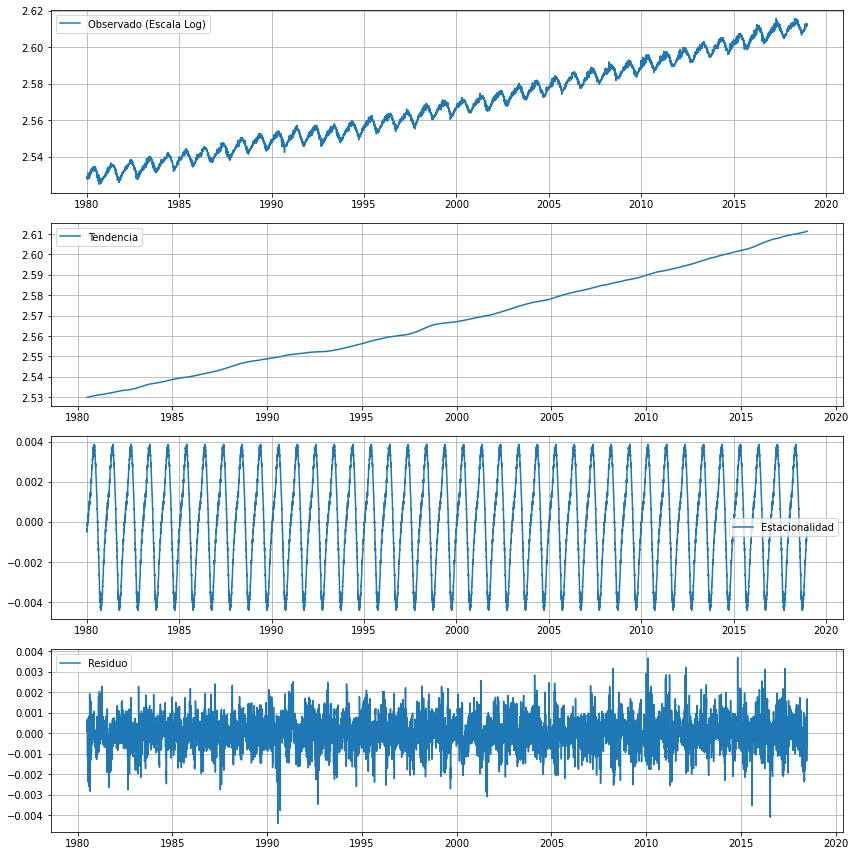

In [277]:
#Descomposición Estacional
#Usando interpolación, y promedio móvil de 365 días.
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')
plt.grid()

#Se observa una tendencia ascendente, tiende a ser una línea recta crecuente.
#SComo esta tendencia corresponde al logaritmo de CO2, podemos decir que 
#que el CO2 aumenta, exponencial por nuestra escala, con respecto al tiempo.
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.grid()

#Se observa que la estacionalidad parece tener un comportamiento uniforme 
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.grid()

#Se observa que el residuo parece tener un comportamiento regular dentro de un rango no muy amplio. 
#Varía muy poco, para comprobar que nuestra observación es cierta, realizamos la prubea.
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')
plt.grid()

#Colocar gráficas lo más cercanas posibles
plt.tight_layout();


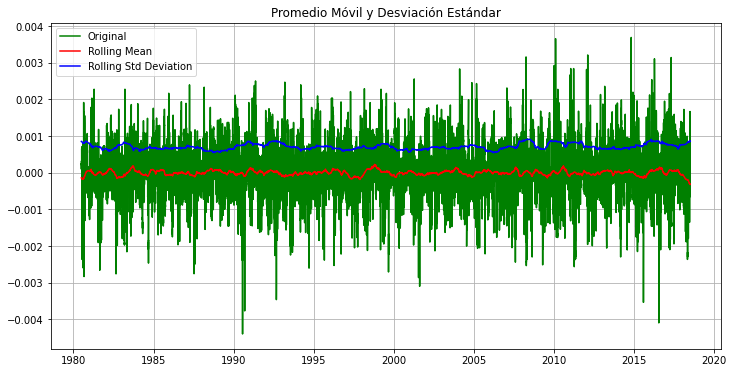

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.847383e+01
p-value                        2.137999e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.385800e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [278]:
#Pruebamos la estacionaria del residuo
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

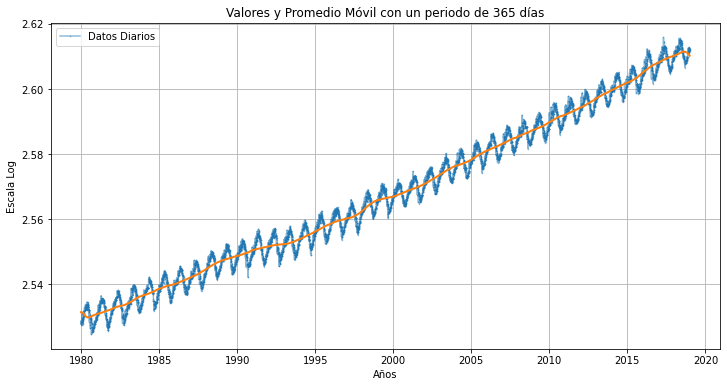

In [279]:
#OBSERVAMOS QUE EFECTIVAMENTE ES ESTACIONARIA 
#YA QUE P ES MENOR A 0.05

#Calculamos el promedio móvil con un periodo de 365 días 
moving_avg = ts_test_log.rolling(365, center=True, min_periods=1).mean()

#Graficamos
fig, ax = plt.subplots()
ax.plot(ts_test_log, marker='.', markersize=1, linestyle='-', alpha=0.5, label='Datos Diarios')
ax.plot(moving_avg, linewidth=2)
#Propiedades de la gráfica
ax.legend()
ax.set_xlabel('Años')
ax.set_ylabel('Escala Log')
ax.set_title('Valores y Promedio Móvil con un periodo de 365 días');
plt.grid()

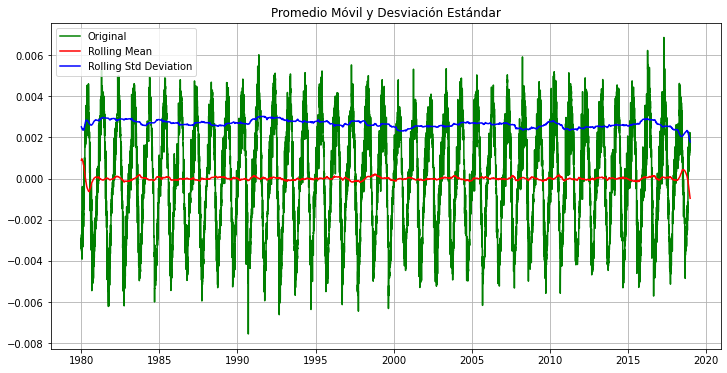

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.424214e+01
p-value                        1.531162e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [280]:
#Nuevo Data Frame
#Este tendrá la diferencia entre la serie logarítmica original y el promedio móvil
ts_diff = ts_test_log - moving_avg 
ts_diff.dropna(inplace=True)
#probamos la estacioaridad 
test_stationarity(ts_diff)

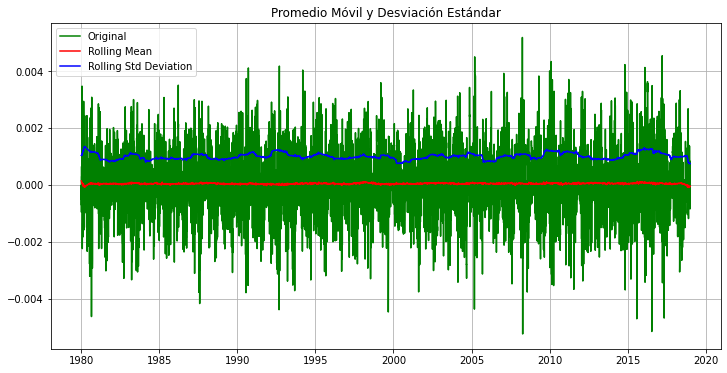

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.876005e+00
p-value                        3.881021e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [281]:
#Construimos una Serie Estacionaria
#Utilizando la función de diferenciación shift
#Periodo elegido, de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

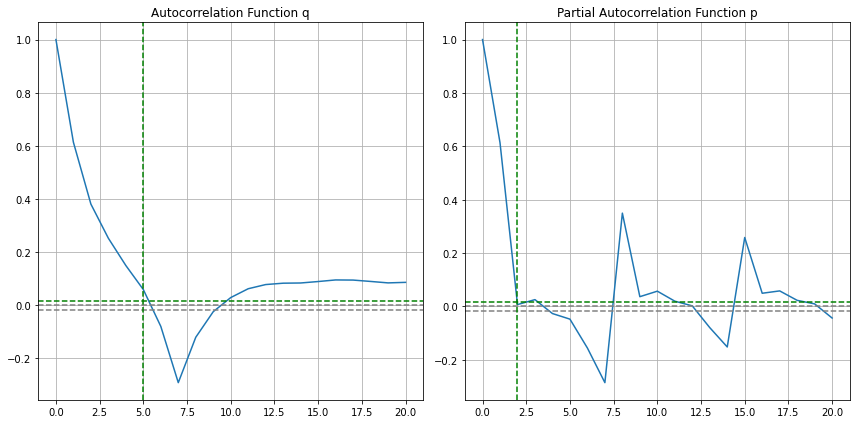

In [282]:
##CONSTRUYENDO UN MODELO ARIMA
#A partir de la serie nombrada como 'ts_test_log_diff'

#Calculamos los parámetros p, q y utilizamos diferenciación d=1
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Graficamos el ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

#Graficamos unas líneas verticales como referencias
plt.axvline(x=5, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function q')

#Graficamos el PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

#Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function p')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood               85371.167
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -170734.334
Time:                        01:16:27   BIC                        -170704.077
Sample:                    01-02-1980   HQIC                       -170724.270
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   3.53e-06      1.665      0.096   -1.04e-06    1.28e-05
ar.L1.D.Value    -0.2427      0.008    -29.505      0.000      -0.259      -0.227
ar.L2.D.Value    -0.1909      0.008    -

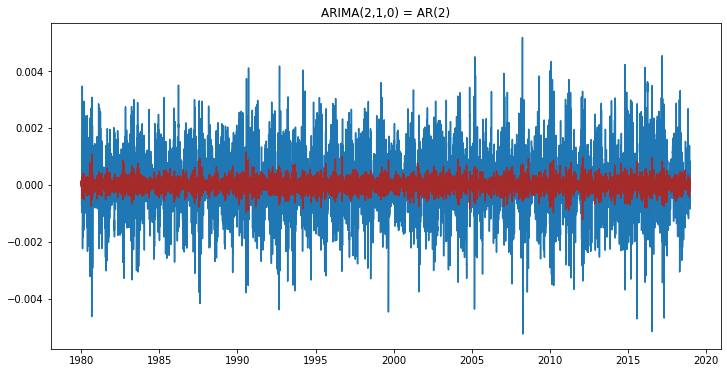

In [270]:
#DEBEMOS ENCONTRAR EL MEJOR MODELO 
#Criterio de Información de Akaike (AIC), donde tenemos que (p,q,d)=(2,1,5)
#MODELOS AR(p), MA(q), y ARIMA (p,d,q). 

# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(0, 1, 5)   Log Likelihood               85673.704
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171333.407
Time:                        01:16:26   BIC                        -171280.459
Sample:                    01-02-1980   HQIC                       -171315.795
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.877e-06   2.09e-06      2.812      0.005    1.78e-06    9.97e-06
ma.L1.D.Value    -0.3000      0.008    -35.793      0.000      -0.316      -0.284
ma.L2.D.Value    -0.1858      0.009    -

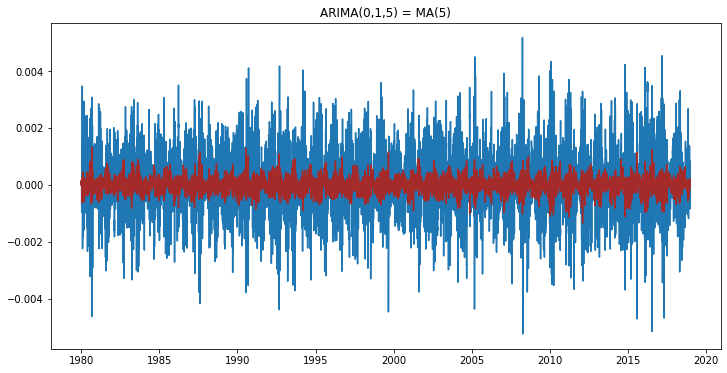

In [269]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model = ARIMA(ts_test_log, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 5)   Log Likelihood               85666.143
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171314.286
Time:                        01:16:16   BIC                        -171246.210
Sample:                    01-02-1980   HQIC                       -171291.642
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06    2.1e-06      2.799      0.005    1.76e-06    9.99e-06
ar.L1.D.Value     0.3253        nan        nan        nan         nan         nan
ar.L2.D.Value     0.2991        nan     

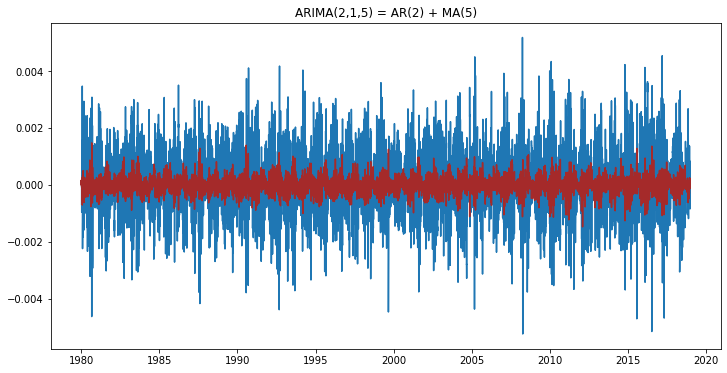

In [268]:
#MODELO ARIMA (p,d,q) = (2,1,5) 
model = ARIMA(ts_test_log, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA.summary())

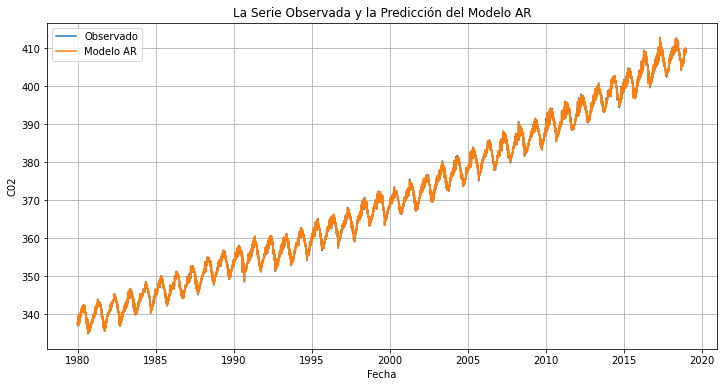

In [293]:
#NOTAMOS QUE LOS VALORES DE AIC PARA CADA MODELO
#AR es  -170734.334
#MA es  -171333.407
#ARIMA es -171314.286

#De lo que podemos decir que el mejor modelo, a partir del Criterio de Información de Akaike (AIC) es AR en nuestro problema

##CONTRASTAMOS LA SERIE OBSERVADA DE CONCENTRACIONES DE C02 CONTRA LA CONSTRUIDA POR EL MODELO AR.
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff)
predictions_AR = 10**(predictions_AR_log)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_AR, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('C02')
plt.title('La Serie Observada y la Predicción del Modelo AR')
plt.legend(loc='best');
plt.grid()


In [294]:
#Calculamos el error RMSE
RMSE = np.sqrt(np.mean((predictions_AR - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.14895510424062794


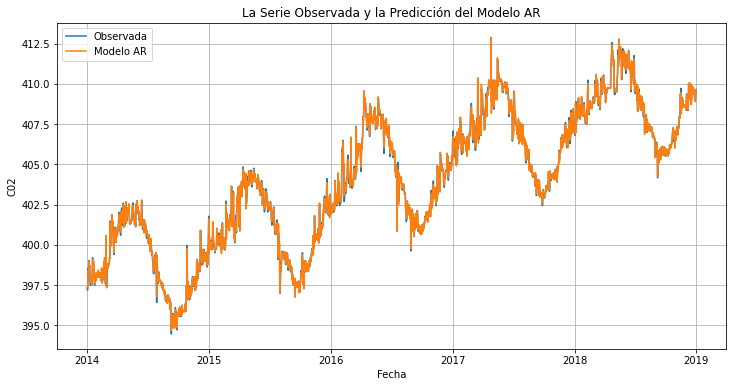

In [295]:
#Contrastamos los últimos 5 años de la Serie de CO2 y el modelo AR
ts_test_last = ts_test.tail(1825)
predictions_AR_last = predictions_AR.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_AR_last, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('C02')
plt.title('La Serie Observada y la Predicción del Modelo AR')
plt.legend(loc='best');
plt.grid()